<a href="https://colab.research.google.com/github/HarisMashood/Homework5_Eye_Tracking/blob/main/Homework_5_Eye_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Import necessary libraries
import pandas as pd

# File paths
file_path = '/content/drive/MyDrive/Homework 5 - Eye Tracking/yarbus_complete_data.csv'

# Load the CSV file
data = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
print("Initial Data Preview:")
print(data.head())

# Define screen boundaries
SCREEN_WIDTH = 1990
SCREEN_HEIGHT = 1200

# Filter out invalid gaze points and points outside the screen boundaries
filtered_data = data[
    (data['validity'] == 'Valid') &
    (data['x'] >= 0) & (data['x'] <= SCREEN_WIDTH) &
    (data['y'] >= 0) & (data['y'] <= SCREEN_HEIGHT)
]

# Normalize timestamps to seconds from the start of the recording
filtered_data['timestamp_seconds'] = (
    filtered_data['timestamp_us'] - filtered_data['timestamp_us'].min()
) / 1_000_000

# Map task codes to full task descriptions
task_descriptions = {
    "free_viewing": "Look at the image freely.",
    "estimate_wealth": "Estimate the material circumstances of the family.",
    "age_estimation": "Estimate the ages of the people in the image.",
    "activity": "What were the people doing before the unexpected visitor arrived?",
    "remember_clothes": "Remember the clothes worn by the people in the image.",
    "furniture": "Remember the positions of the objects and people in the room.",
}
filtered_data['task_description'] = filtered_data['task'].map(task_descriptions)

# Display a preview of the filtered data
print("\nFiltered Data Preview:")
print(filtered_data.head())

# Save the preprocessed data to a new CSV file in Google Drive
preprocessed_file_path = '/content/drive/MyDrive/Homework 5 - Eye Tracking/yarbus_preprocessed_data.csv'
filtered_data.to_csv(preprocessed_file_path, index=False)

print(f"\nPreprocessed data saved at: {preprocessed_file_path}")

Initial Data Preview:
             x           y validity   timestamp_us          task
0  1407.382080  479.778687    Valid  1863999707017  free_viewing
1  1407.162842  480.453064    Valid  1863999737161  free_viewing
2  1406.528931  480.837677    Valid  1863999767419  free_viewing
3  1406.229370  481.434814    Valid  1863999797563  free_viewing
4  1402.487183  481.662781    Valid  1863999827803  free_viewing

Filtered Data Preview:
             x           y validity   timestamp_us          task  \
0  1407.382080  479.778687    Valid  1863999707017  free_viewing   
1  1407.162842  480.453064    Valid  1863999737161  free_viewing   
2  1406.528931  480.837677    Valid  1863999767419  free_viewing   
3  1406.229370  481.434814    Valid  1863999797563  free_viewing   
4  1402.487183  481.662781    Valid  1863999827803  free_viewing   

   timestamp_seconds           task_description  
0           0.000000  Look at the image freely.  
1           0.030144  Look at the image freely.  
2    

<ipython-input-5-e181bea3e873>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['timestamp_seconds'] = (
<ipython-input-5-e181bea3e873>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['task_description'] = filtered_data['task'].map(task_descriptions)


<ipython-input-8-65b66df95d76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['y_flipped'] = image.shape[0] - filtered_data['y']


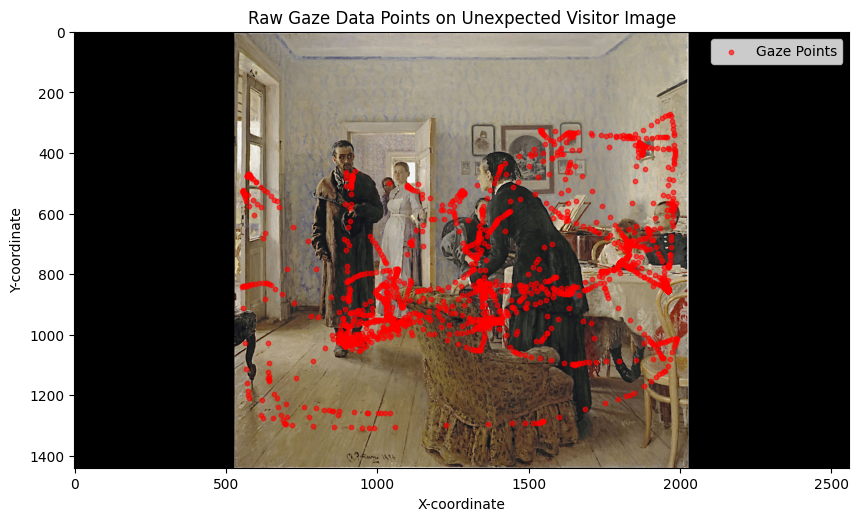

In [8]:
# Y-coordinates for the inverted image
filtered_data['y_flipped'] = image.shape[0] - filtered_data['y']

# Plot raw gaze data points on the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.scatter(
    filtered_data['x'],
    filtered_data['y_flipped'],
    s=10,
    c='red',
    alpha=0.6,
    label='Gaze Points'
)
plt.title('Raw Gaze Data Points on Unexpected Visitor Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

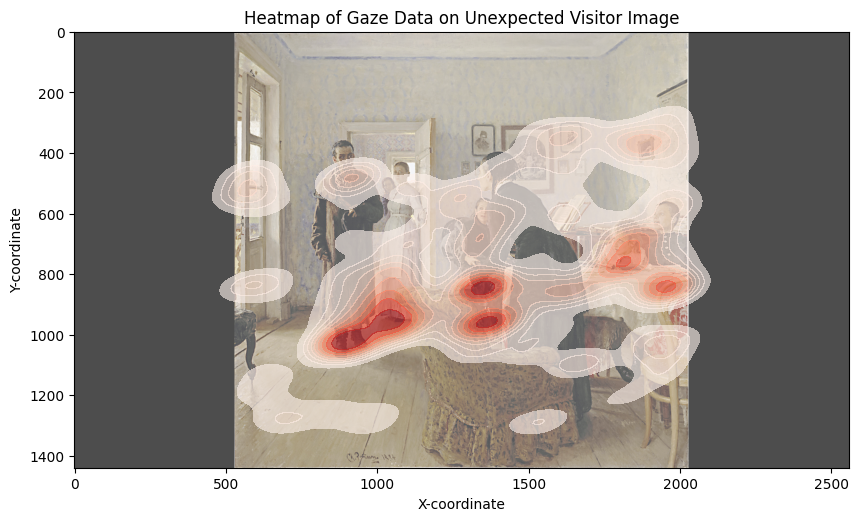

In [9]:
# Create a heatmap of gaze points
plt.figure(figsize=(10, 8))
plt.imshow(image, alpha=0.7)  # Add the image as the background
sns.kdeplot(
    x=filtered_data['x'],
    y=filtered_data['y_flipped'],
    cmap='Reds',
    fill=True,
    alpha=0.6,
    bw_adjust=0.5
)
plt.title('Heatmap of Gaze Data on Unexpected Visitor Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.show()

In [14]:
def smi_velocity_algorithm(data, velocity_threshold=30, saccade_peak_location_threshold=0.8):
    """
    Implements the SMI velocity-based algorithm for eye movement classification.
    """
    # Step 1: Calculate velocities
    velocities = []
    for i in range(1, len(data)):
        dx = data['x'].iloc[i] - data['x'].iloc[i-1]
        dy = data['y'].iloc[i] - data['y'].iloc[i-1]
        dt = data['timestamp_seconds'].iloc[i] - data['timestamp_seconds'].iloc[i-1]
        if dt > 0:
            velocity = np.sqrt(dx**2 + dy**2) / dt
            velocities.append(velocity)
        else:
            velocities.append(0)

    velocities = np.array(velocities)
    velocity_mean = np.mean(velocities)
    velocity_std = np.std(velocities)
    fixation_velocity_threshold = velocity_mean + 3 * velocity_std

    # Step 2: Identify saccades (peaks)
    saccades = []
    for i in range(1, len(velocities) - 1):
        if velocities[i] > velocity_threshold and velocities[i] > velocities[i-1] and velocities[i] > velocities[i+1]:
            onset, offset = i, i
            while onset > 0 and velocities[onset] > fixation_velocity_threshold:
                onset -= 1
            while offset < len(velocities) - 1 and velocities[offset] > fixation_velocity_threshold:
                offset += 1

            # Ensure onset and offset are valid
            if offset - onset > 0:  # Prevent division by zero
                peak_centrality = (i - onset) / (offset - onset)
                if peak_centrality > (1 - saccade_peak_location_threshold) and peak_centrality < saccade_peak_location_threshold:
                    saccades.append((onset, offset))

    # Step 3: Detect blinks
    blinks = []
    for i in range(1, len(data)):
        if data['x'].iloc[i] == 0 and data['y'].iloc[i] == 0:
            start = i
            while i < len(data) and data['x'].iloc[i] == 0 and data['y'].iloc[i] == 0:
                i += 1
            blinks.append((start, i))

    # Step 4: Identify fixations
    fixations = []
    classified = set(np.concatenate([np.arange(onset, offset) for onset, offset in saccades] +
                                     [np.arange(start, end) for start, end in blinks]))
    for i in range(len(data)):
        if i not in classified:
            start = i
            while i < len(data) and i not in classified:
                i += 1
            fixations.append((start, i))

    return saccades, fixations, blinks

In [18]:
def visualize_eye_movements(data, saccades, fixations, blinks, image):
    """
    Visualize the detected saccades, fixations, and blinks on the "Unexpected Visitor" image.

    Args:
    - data: Original eye-tracking data.
    - saccades: List of (onset, offset) tuples for saccades.
    - fixations: List of (start, end) tuples for fixations.
    - blinks: List of (start, end) tuples for blinks.
    - image: Loaded image for background visualization.
    """
    # Flip Y-coordinates to align with the image
    data['y_flipped'] = image.shape[0] - data['y']

    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    # Plot fixations
    for fixation in fixations:
        fixation_points = data.iloc[fixation[0]:fixation[1]]
        plt.scatter(
            fixation_points['x'],
            fixation_points['y_flipped'],
            s=20,
            c='blue',
            alpha=0.6,
            label='Fixation' if 'Fixation' not in plt.gca().get_legend_handles_labels()[1] else ""
        )

    # Plot saccades
    for saccade in saccades:
        saccade_points = data.iloc[saccade[0]:saccade[1]]
        plt.plot(
            saccade_points['x'],
            saccade_points['y_flipped'],
            c='green',
            linewidth=1.5,
            label='Saccade' if 'Saccade' not in plt.gca().get_legend_handles_labels()[1] else ""
        )

    # Plot blinks
    for blink in blinks:
        blink_points = data.iloc[blink[0]:blink[1]]
        plt.scatter(
            blink_points['x'],
            blink_points['y_flipped'],
            s=10,
            c='red',
            alpha=0.6,
            label='Blink' if 'Blink' not in plt.gca().get_legend_handles_labels()[1] else ""
        )

    plt.title('Visualization of Fixations, Saccades, and Blinks on the Unexpected Visitor Image')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

<ipython-input-18-44226675407b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_flipped'] = image.shape[0] - data['y']


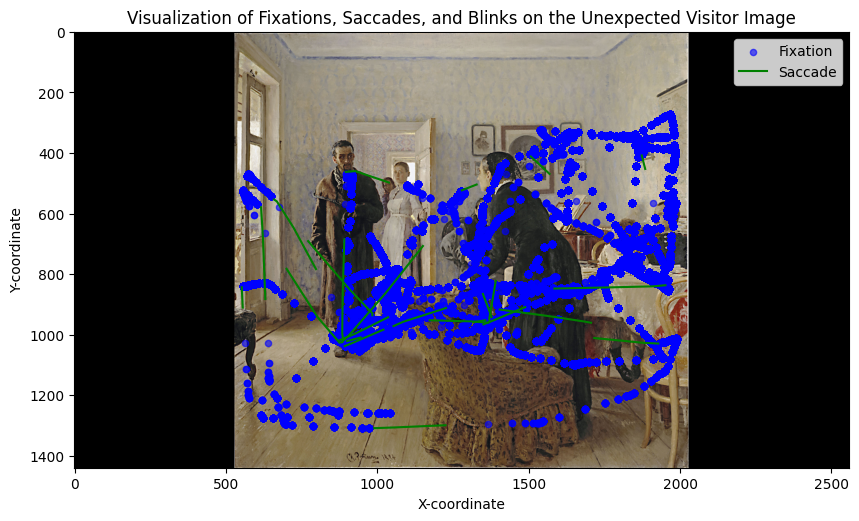

In [19]:
saccades, fixations, blinks = smi_velocity_algorithm(filtered_data)

visualize_eye_movements(filtered_data, saccades, fixations, blinks, image)

<ipython-input-20-67ceb71f5324>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_flipped'] = image.shape[0] - data['y']


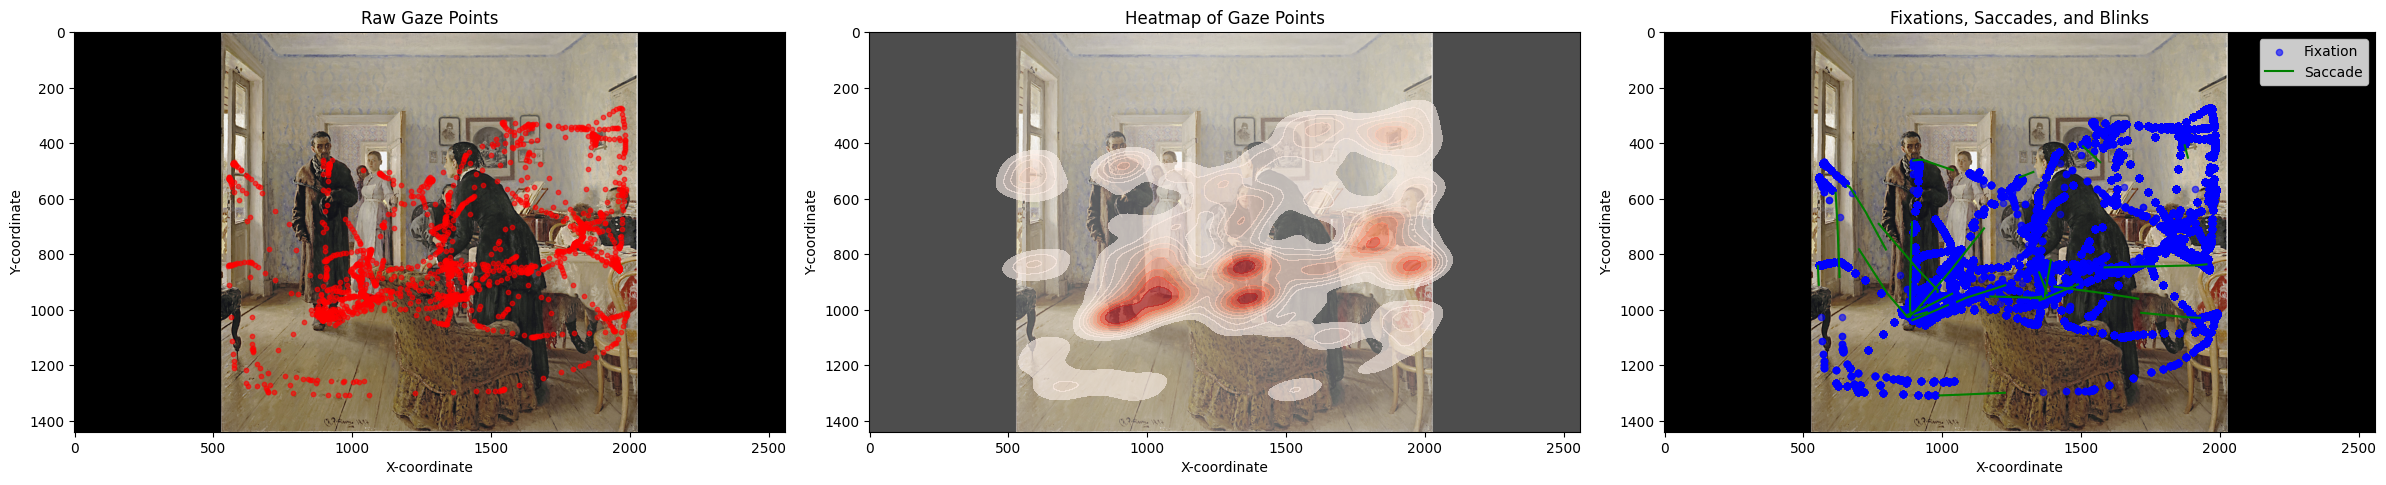

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_side_by_side(data, saccades, fixations, blinks, image):
    # Flip Y-coordinates for proper alignment
    data['y_flipped'] = image.shape[0] - data['y']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: Raw gaze points
    axes[0].imshow(image)
    axes[0].scatter(data['x'], data['y_flipped'], s=10, c='red', alpha=0.6)
    axes[0].set_title('Raw Gaze Points')
    axes[0].set_xlabel('X-coordinate')
    axes[0].set_ylabel('Y-coordinate')

    # Plot 2: Heatmap of gaze points
    axes[1].imshow(image, alpha=0.7)
    sns.kdeplot(
        x=data['x'],
        y=data['y_flipped'],
        cmap='Reds',
        fill=True,
        alpha=0.6,
        bw_adjust=0.5,
        ax=axes[1]
    )
    axes[1].set_title('Heatmap of Gaze Points')
    axes[1].set_xlabel('X-coordinate')
    axes[1].set_ylabel('Y-coordinate')

    # Plot 3: Fixations, saccades, and blinks
    axes[2].imshow(image)
    for fixation in fixations:
        fixation_points = data.iloc[fixation[0]:fixation[1]]
        axes[2].scatter(fixation_points['x'], fixation_points['y_flipped'], s=20, c='blue', alpha=0.6, label='Fixation')
    for saccade in saccades:
        saccade_points = data.iloc[saccade[0]:saccade[1]]
        axes[2].plot(saccade_points['x'], saccade_points['y_flipped'], c='green', linewidth=1.5, label='Saccade')
    for blink in blinks:
        blink_points = data.iloc[blink[0]:blink[1]]
        axes[2].scatter(blink_points['x'], blink_points['y_flipped'], s=10, c='red', alpha=0.6, label='Blink')
    axes[2].set_title('Fixations, Saccades, and Blinks')
    axes[2].set_xlabel('X-coordinate')
    axes[2].set_ylabel('Y-coordinate')

    # Ensure legends don't overlap
    handles, labels = axes[2].get_legend_handles_labels()
    unique_labels = {label: handle for handle, label in zip(handles, labels)}
    axes[2].legend(unique_labels.values(), unique_labels.keys())

    plt.tight_layout()
    plt.show()


# Call the function to generate the plots
plot_side_by_side(filtered_data, saccades, fixations, blinks, image)

<ipython-input-21-433caac85a92>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_flipped'] = image.shape[0] - data['y']


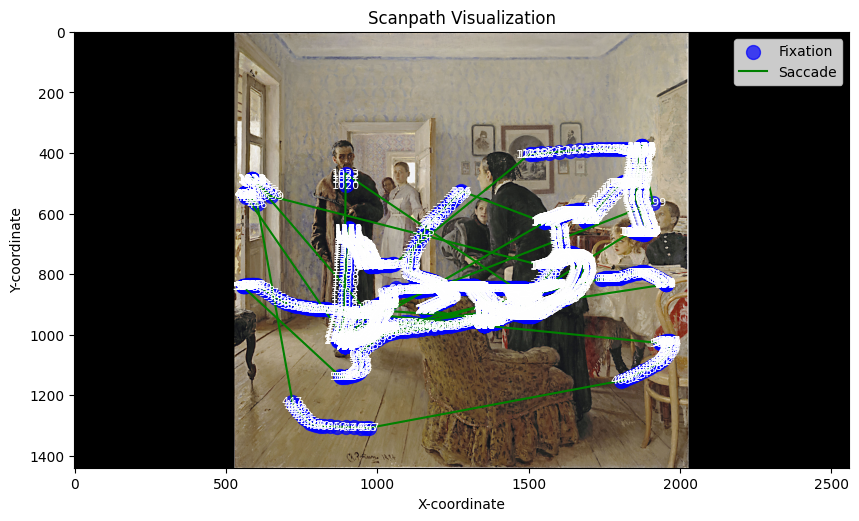

Scanpath Metrics:
Average Fixation Duration (s): 2.5878288473958344
Saccade Lengths (px): [1.3106742507055362, 1.609640084422901, 1.9803494237413244, 2.596410120140465, 2.894198063402028, 2.8375584986811635, 2.8132923936468406, 2.785597857193757, 2.491788170372556, 465.35527854735767]... (showing first 10 values)


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def scanpath_analysis(data, fixations, image):
    """
    Perform scanpath analysis by visualizing fixations and calculating metrics.

    Args:
    - data: Preprocessed eye-tracking data.
    - fixations: List of (start, end) tuples for fixations.
    - image: Loaded image for background visualization.

    Returns:
    - Metrics: Dictionary containing average fixation duration and saccade lengths.
    """
    # Flip Y-coordinates for alignment
    data['y_flipped'] = image.shape[0] - data['y']

    # Prepare fixation points
    fixation_centers = []
    fixation_durations = []

    for fixation in fixations:
        fixation_points = data.iloc[fixation[0]:fixation[1]]
        center_x = fixation_points['x'].mean()
        center_y = fixation_points['y_flipped'].mean()
        duration = fixation_points['timestamp_seconds'].iloc[-1] - fixation_points['timestamp_seconds'].iloc[0]

        fixation_centers.append((center_x, center_y))
        fixation_durations.append(duration)

    # Calculate metrics
    avg_fixation_duration = np.mean(fixation_durations)
    saccade_lengths = [
        np.sqrt((fixation_centers[i+1][0] - fixation_centers[i][0])**2 +
                (fixation_centers[i+1][1] - fixation_centers[i][1])**2)
        for i in range(len(fixation_centers) - 1)
    ]

    metrics = {
        "Average Fixation Duration (s)": avg_fixation_duration,
        "Saccade Lengths (px)": saccade_lengths
    }

    # Scanpath Visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    for i, (x, y) in enumerate(fixation_centers):
        plt.scatter(x, y, c='blue', s=100, alpha=0.7, label='Fixation' if i == 0 else "")
        plt.text(x, y, str(i+1), color="white", fontsize=8, ha="center", va="center")
    for i in range(len(fixation_centers) - 1):
        x1, y1 = fixation_centers[i]
        x2, y2 = fixation_centers[i + 1]
        plt.plot([x1, x2], [y1, y2], c='green', linewidth=1.5, label='Saccade' if i == 0 else "")

    plt.title('Scanpath Visualization')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

    return metrics


# Run Scanpath Analysis
metrics = scanpath_analysis(filtered_data, fixations, image)

# Print Metrics
print("Scanpath Metrics:")
for key, value in metrics.items():
    if isinstance(value, list):  # For saccade lengths
        print(f"{key}: {value[:10]}... (showing first 10 values)")  # Truncate long lists
    else:
        print(f"{key}: {value}")